In [1]:
from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import tensorflow
import keras
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, VGG19
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('drive/Shareddrives/Machine Learning Project/UTK_Face0521.csv')

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


**EDA**

In [5]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [6]:
df = df.drop(['img_name','ethnicity'], axis=1)

Text(0.5, 1.0, 'Number of Images by Age in UTK Face Dataset')

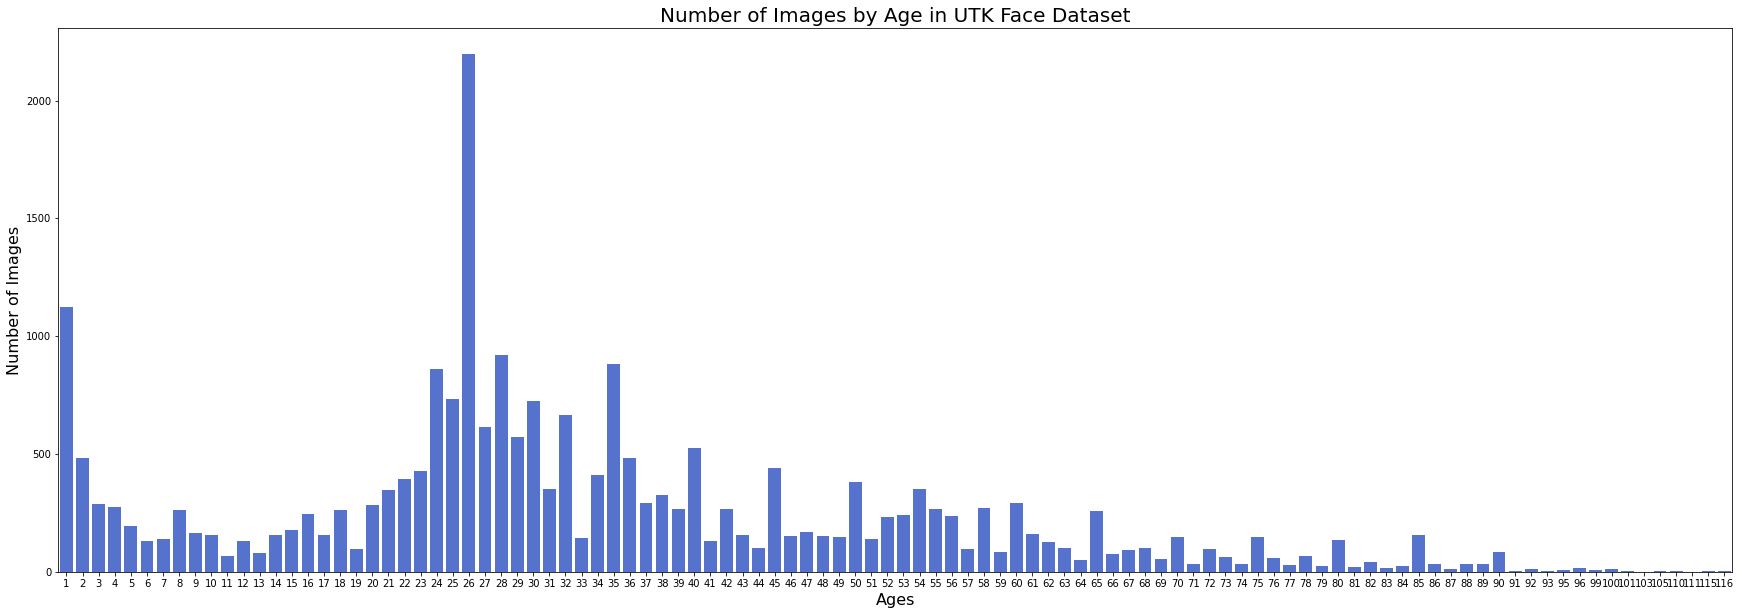

In [7]:
ages, counts = np.unique(df.age, return_counts=True)
d = dict(zip(ages, counts))
d = {int(k):int(v) for k,v in d.items()}
plt.figure(figsize=(30, 10))
ax = sns.barplot(x=list(d.keys()), y=list(d.values()), color='royalblue')
plt.xlabel("Ages", fontsize=16)
plt.ylabel("Number of Images", fontsize=16)
plt.title("Number of Images by Age in UTK Face Dataset", fontsize=20)

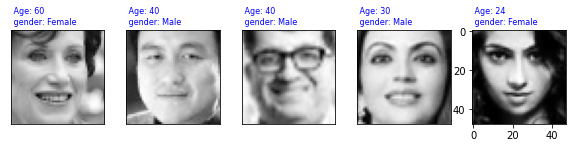

In [8]:
plt.figure(figsize=(10, 10))
for i in range(5):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32')).iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n gender: {}'.format(df['age'].iloc[index], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='blue',fontsize = 8)
plt.show()

In [9]:
def class_labels(age):
    if 0 <= age <= 14:
        return 0
    elif 15 <= age <= 24:
        return 1
    elif 25 <= age <= 28:
        return 2
    elif 28 < age <= 33:
        return 3
    elif 34 <= age <= 45:
        return 4
    elif 46 <= age <= 60:
        return 5
    else:
        return 6

In [10]:
df['target'] = df['age'].map(class_labels)

In [11]:
df.head()

,age,gender,pixels,target
0,1,0,129 128 128 126 127 130 133 135 139 142 145 14...,0
1,1,0,164 74 111 168 169 171 175 182 184 188 193 199...,0
2,1,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,0
3,1,0,193 197 198 200 199 200 202 203 204 205 208 21...,0
4,1,0,202 205 209 210 209 209 210 211 212 214 218 21...,0


In [12]:
num_pixels = len(df['pixels'][0].split(' '))
img_height = np.sqrt(num_pixels)
img_width = np.sqrt(num_pixels)

In [13]:
print(num_pixels, img_height, img_width)

2304 48.0 48.0


In [14]:
y = df['target']
X = df['pixels']

In [15]:
X = X.apply(lambda x: x.split(' '))
X = X.apply(lambda x: np.array(list(map(lambda z: np.float(z), x))))
X = np.array(X)
X = np.stack(np.array(X), axis=0)
X = np.reshape(X, (-1, 48, 48))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [16]:
X.shape

(23705, 48, 48)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [18]:
num_classes = 7
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print(X_train.shape)
print(y_train.shape)

(16593, 48, 48)
(16593, 7)


In [19]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

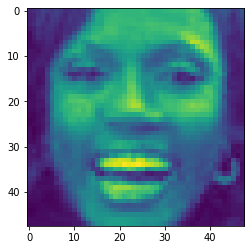

In [25]:
plt.imshow(X_train[0].reshape(48, 48))

**CNN**

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

datagen.fit(X_train)

print(X_train.shape, y_train.shape)

(16593, 48, 48, 1) (16593, 7)


In [ ]:
model1 = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(7,activation='softmax')
])

model1.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 56448)             0         
                                                                 
 dropout_2 (Dropout)         (None, 56448)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                3612736   
                                                      

In [31]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

In [ ]:
batch_size=64
epochs=3

In [ ]:
model1.fit(X_train, y_train, 
          batch_size=batch_size, 
          epochs=epochs,
          validation_data=(X_test, y_test),
          callbacks=[early_stopping_cb])

Epoch 1/3
260/260 [==============================] - 133s 510ms/step - loss: 1.5117 - accuracy: 0.3905 - val_loss: 1.3737 - val_accuracy: 0.4490
Epoch 2/3
260/260 [==============================] - 128s 494ms/step - loss: 1.3113 - accuracy: 0.4662 - val_loss: 1.3305 - val_accuracy: 0.4570
Epoch 3/3
260/260 [==============================] - 157s 605ms/step - loss: 1.2402 - accuracy: 0.4927 - val_loss: 1.3331 - val_accuracy: 0.4428


**Complicated CNN**

In [32]:
model2 = Sequential([
    Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(48,48,1)),
    MaxPooling2D(2,2), 
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(7,activation='softmax')
])

model2.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

In [33]:
model2_history = model2.fit(X_train, y_train, 
                            batch_size=128, 
                            epochs=60,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping_cb])

Epoch 1/60
130/130 [==============================] - 62s 471ms/step - loss: 1.8261 - accuracy: 0.2505 - val_loss: 1.5488 - val_accuracy: 0.3742
Epoch 2/60
130/130 [==============================] - 62s 473ms/step - loss: 1.4648 - accuracy: 0.4010 - val_loss: 1.3988 - val_accuracy: 0.4258
Epoch 3/60
130/130 [==============================] - 62s 476ms/step - loss: 1.3180 - accuracy: 0.4604 - val_loss: 1.3087 - val_accuracy: 0.4521
Epoch 4/60
130/130 [==============================] - 67s 514ms/step - loss: 1.2419 - accuracy: 0.4865 - val_loss: 1.2575 - val_accuracy: 0.4813
Epoch 5/60
130/130 [==============================] - 63s 487ms/step - loss: 1.1893 - accuracy: 0.5073 - val_loss: 1.2259 - val_accuracy: 0.4857
Epoch 6/60
130/130 [==============================] - 64s 495ms/step - loss: 1.1421 - accuracy: 0.5214 - val_loss: 1.2273 - val_accuracy: 0.4862
Epoch 7/60
130/130 [==============================] - 64s 494ms/step - loss: 1.0943 - accuracy: 0.5406 - val_loss: 1.2008 - val_ac

In [34]:
import plotly.express as px
fig = px.line(
    model2_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Age Model"
)

fig.show()

In [35]:
loss, acc = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.1976125240325928
Test Accuracy: 0.499015748500824


In [37]:
y_pred = model2.predict(X_test)

In [40]:
y_pred = np.argmax(y_pred, axis=1)

In [44]:
y_test = np.argmax(y_test, axis=1)

In [45]:
cf_matrix = confusion_matrix(y_test, y_pred)

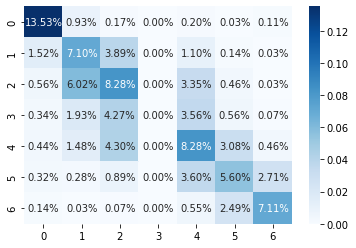

In [46]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [47]:
cmd_obj = ConfusionMatrixDisplay(cf_matrix, display_labels=['1-14', '15-24', '25-28', '29-33', '34-45','46-60', '60+'])

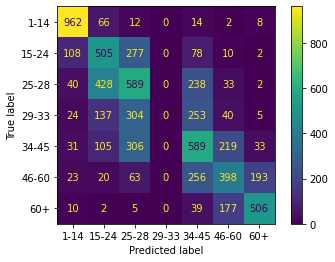

In [48]:
cmd_obj.plot()

**VAE**

In [20]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [21]:
latent_dim = 3
encoder_inputs = layers.Input(shape = (48,48,1))
x = layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_inputs)
x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x)
x = layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
x = layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (3,3))(x)
x = layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu')(x)
x = layers.Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu')(x)
x = layers.MaxPool2D(pool_size = (2,2))(x)

x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 46, 46, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 23, 23, 64)   0           ['conv2d_1[0][0]']               
                                                                                            

In [22]:
decoder_input = layers.Input(shape = (latent_dim,))

x = layers.Dense(12*12*32, activation = 'relu')(decoder_input)

x = layers.Reshape((12,12,32))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(filters = 1, kernel_size = (3,3), padding = 'same')(x)

decoder = tf.keras.Model(decoder_input, x)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 4608)              18432     
                                                                 
 reshape (Reshape)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 24, 64)       18496     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 48, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 1)         577   

In [23]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [24]:
vae = VAE(encoder, decoder)

In [25]:
vae.compile(optimizer=tf.keras.optimizers.Adam())
model3_history = vae.fit(X_train, epochs=10, batch_size=128)

Epoch 1/10
130/130 [==============================] - 417s 3s/step - loss: 2577.6018 - reconstruction_loss: 1855.3925 - kl_loss: 13.5567
Epoch 2/10
130/130 [==============================] - 412s 3s/step - loss: 1533.3799 - reconstruction_loss: 1507.5376 - kl_loss: 7.2109
Epoch 3/10
130/130 [==============================] - 416s 3s/step - loss: 1465.1836 - reconstruction_loss: 1452.9911 - kl_loss: 9.0317
Epoch 4/10
130/130 [==============================] - 416s 3s/step - loss: 1454.4265 - reconstruction_loss: 1444.6151 - kl_loss: 8.5114
Epoch 5/10
130/130 [==============================] - 420s 3s/step - loss: 1451.8021 - reconstruction_loss: 1444.2557 - kl_loss: 8.3162
Epoch 6/10
130/130 [==============================] - 425s 3s/step - loss: 1448.7001 - reconstruction_loss: 1439.5548 - kl_loss: 8.1563
Epoch 7/10
130/130 [==============================] - 425s 3s/step - loss: 1490.5123 - reconstruction_loss: 1472.9159 - kl_loss: 7.5094
Epoch 8/10
130/130 [===========================